In [11]:
import os
import glob
import numpy as np
import cv2
import json
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import MeanIoU


In [6]:
def load_data(image_folder, annotation_folder):
    image_files = glob.glob(os.path.join(image_folder, "*.jpeg"))
    images, masks = [], []

    for img_path in image_files:
        # Đọc ảnh X-quang
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (256, 256))
        image = image / 255.0  # Chuẩn hóa về [0,1]

        # Đọc annotation JSON
        json_path = os.path.join(annotation_folder, os.path.basename(img_path).replace(".jpeg", ".json"))
        mask = np.zeros((256, 256), dtype=np.uint8)  # Mặc định là mask toàn màu đen

        if os.path.exists(json_path):
            with open(json_path, 'r') as f:
                annotation = json.load(f)

            for shape in annotation["shapes"]:
                points = np.array(shape["points"], dtype=np.int32)
                cv2.fillPoly(mask, [points], 1)  # Vẽ vùng khối u lên mask

        # Định dạng lại mask cho TensorFlow
        mask = np.expand_dims(mask, axis=-1)  # Thêm channel (256,256,1)
        images.append(image.reshape(256, 256, 1))
        masks.append(mask)

    return np.array(images), np.array(masks)

# Đường dẫn dữ liệu trên Kaggle
image_folder = r"C:\Users\thres\Downloads\BTXRD\images"
annotation_folder = r"C:\Users\thres\Downloads\BTXRD\Annotations"

# Load dữ liệu
X, Y = load_data(image_folder, annotation_folder)
print(f"✅ Dữ liệu đã load: X shape {X.shape}, Y shape {Y.shape}")


✅ Dữ liệu đã load: X shape (3719, 256, 256, 1), Y shape (3719, 256, 256, 1)


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
print(f"✅ Tập train: {X_train.shape}, Tập test: {X_test.shape}")


✅ Tập train: (2603, 256, 256, 1), Tập test: (1116, 256, 256, 1)


In [ ]:
def build_seg_unet(input_shape=(256, 256, 1)):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u5)

    u6 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)

    u7 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

# Xây dựng mô hình
model = build_seg_unet()
model.summary()


NameError: name 'Input' is not defined

In [9]:
# Compile mô hình
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', MeanIoU(num_classes=2)])

# Huấn luyện mô hình
history = model.fit(X_train, Y_train,
                    batch_size=16,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_test, Y_test))

# Đánh giá mô hình
score = model.evaluate(X_test, Y_test, verbose=0)
print(f"✅ Test Loss: {score[0]:.4f}")
print(f"✅ Test Accuracy: {score[1]*100:.2f}%")
print(f"✅ Test IoU: {score[2]:.4f}")


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.9637 - loss: 0.1349 - mean_io_u: 0.5015 - val_accuracy: 0.9961 - val_loss: 0.0383 - val_mean_io_u: 0.4980
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.9965 - loss: 0.0287 - mean_io_u: 0.4982 - val_accuracy: 0.9961 - val_loss: 0.0250 - val_mean_io_u: 0.4980
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.9971 - loss: 0.0233 - mean_io_u: 0.4985 - val_accuracy: 0.9961 - val_loss: 0.0263 - val_mean_io_u: 0.4980
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.9966 - loss: 0.0251 - mean_io_u: 0.4983 - val_accuracy: 0.9961 - val_loss: 0.0260 - val_mean_io_u: 0.4980
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.9973 - loss: 0.0251 - mean_io_u: 0.4987 - val_accuracy: 0.9961 - val_loss: 0.0254 - val_mean_io_u: 0.4980
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.9969 - loss: 0.0213 - mean_io_u: 0.4985 - val_accuracy: 0.9961 - val

In [10]:
model.save("D:\code\project\Chien_BTW4\segmentation_model.h5")
print("✅ Mô hình đã được lưu")

✅ Mô hình đã được lưu


In [9]:
model = load_model("D:\code\project\Chien_BTW4\segmentation_model.h5")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Nếu bạn chỉ có file .h5 chứa weights, cần build lại mô hình trước khi load
print("✅ Hàm build_seg_unet có sẵn" if "build_seg_unet" in globals() else "❌ Hàm build_seg_unet chưa được định nghĩa!")


✅ Hàm build_seg_unet có sẵn


In [2]:
from tensorflow.keras.models import load_model

# Load mô hình Seg-Unet đã huấn luyện
heatmodel = load_model("D:\code\project\Chien_BTW4\segmentation_model.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


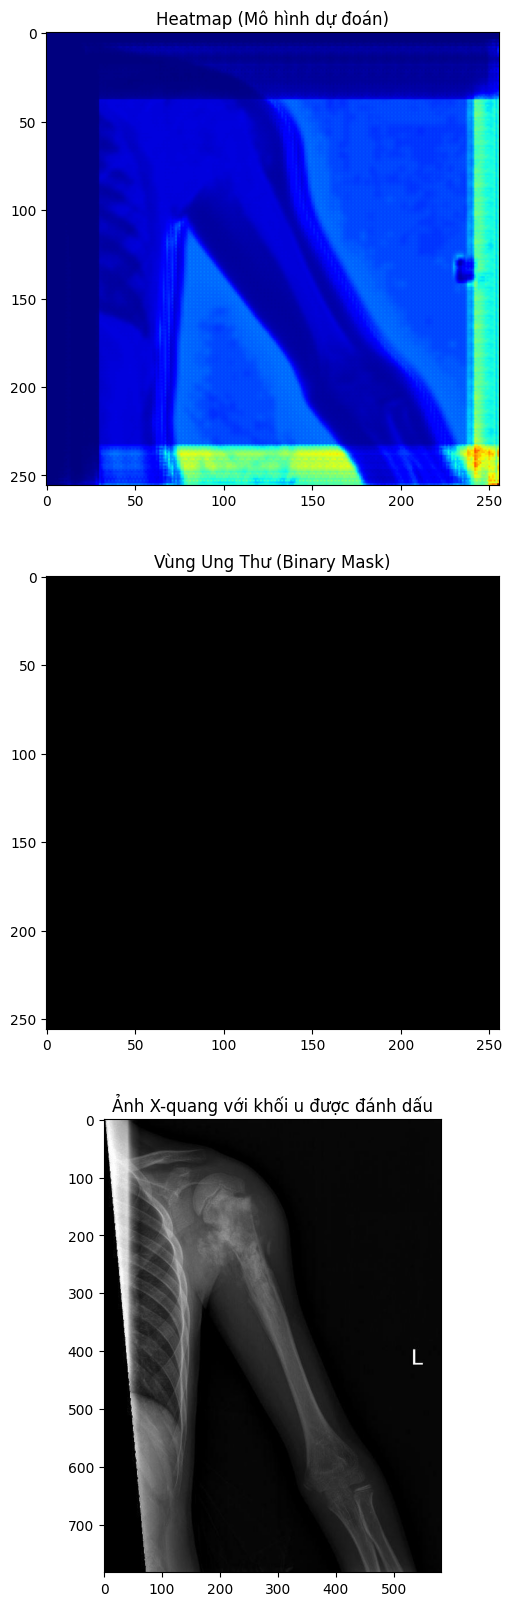

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load mô hình Seg-Unet đã huấn luyện
heatmodel = load_model("D:\code\project\Chien_BTW4\segmentation_model.h5")

def locate():
    # Đọc ảnh X-quang grayscale
    data = cv2.imread("IMG000105.jpeg", cv2.IMREAD_GRAYSCALE)
    
    # Resize ảnh về 256x256 (giống như khi train mô hình)
    data_resized = cv2.resize(data, (256, 256)) / 255.0  # Chuẩn hóa về [0,1]
    data_resized = np.expand_dims(data_resized, axis=-1)  # Thêm channel (256,256,1)
    data_resized = np.expand_dims(data_resized, axis=0)   # Thêm batch dimension (1,256,256,1)
    
    # Dự đoán heatmap vùng ung thư
    heatmap = heatmodel.predict(data_resized)[0, :, :, 0]

    # Tạo mask vùng nghi ngờ ung thư (ngưỡng > 0.5)
    sel_heatmap = heatmap > 0.5
    
    # Chuyển ảnh gốc sang 3 kênh để vẽ màu
    data_colored = cv2.cvtColor(data, cv2.COLOR_GRAY2BGR)

    # Vẽ vùng nghi ngờ ung thư trên ảnh
    contours, _ = cv2.findContours(sel_heatmap.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(data_colored, (x, y), (x+w, y+h), (0, 255, 0), 2)

    return heatmap, sel_heatmap, data_colored

# Gọi hàm locate() để tìm khối u
hm, sel_hm, annotated = locate()

# Hiển thị kết quả
plt.figure(figsize=(10, 20))

plt.subplot(3, 1, 1)
plt.title("Heatmap (Mô hình dự đoán)")
plt.imshow(hm, cmap="jet")

plt.subplot(3, 1, 2)
plt.title("Vùng Ung Thư (Binary Mask)")
plt.imshow(sel_hm, cmap="gray")

plt.subplot(3, 1, 3)
plt.title("Ảnh X-quang với khối u được đánh dấu")
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))

plt.show()